In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df= pd.read_csv('/content/GVT data.csv')

In [3]:
df.head()

,Team ID,Virtuality %,date,reopen count,duration,Updated
0,Global 11,96,01/01/2018,0,1445,5
1,Americas 1,82,01/01/2018,0,1583,7
2,US 2,7,01/01/2018,0,25,6
3,US 2,7,01/01/2018,0,26,8
4,Global 5,98,01/01/2018,0,1198,5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59267 entries, 0 to 59266
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Team ID       59267 non-null  object
 1   Virtuality %  59267 non-null  int64 
 2   date          59267 non-null  object
 3   reopen count  59267 non-null  int64 
 4   duration      59267 non-null  int64 
 5   Updated       59267 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 2.7+ MB


1. Virtuality % = Cât de mult lucrează echipa remote
2. reopen count = De cate ori a fost refăcut un task
3. duration = Timpul unui task
4. Updated = Cat de des a fost modificat un task de la inceput pana la reopen

In [5]:
df.shape


(59267, 6)

In [6]:
df.isnull().sum()

,0
Team ID,0
Virtuality %,0
date,0
reopen count,0
duration,0
Updated,0


In [7]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8,5)

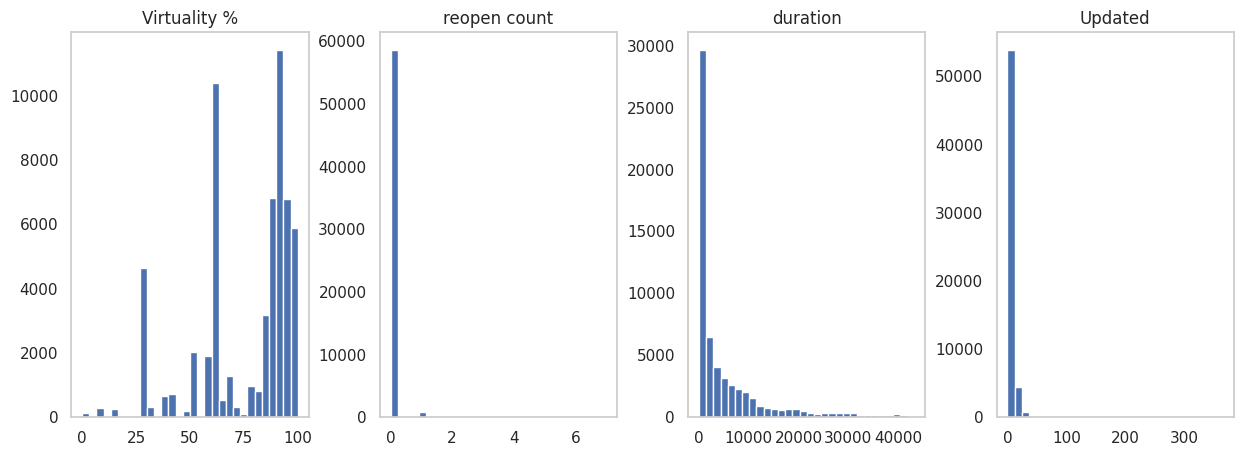

In [8]:
numeric_cols = ['Virtuality %', 'reopen count', 'duration', 'Updated']

df[numeric_cols].hist(bins=30, figsize=(15,5), layout=(1,4), grid=False)
plt.show()


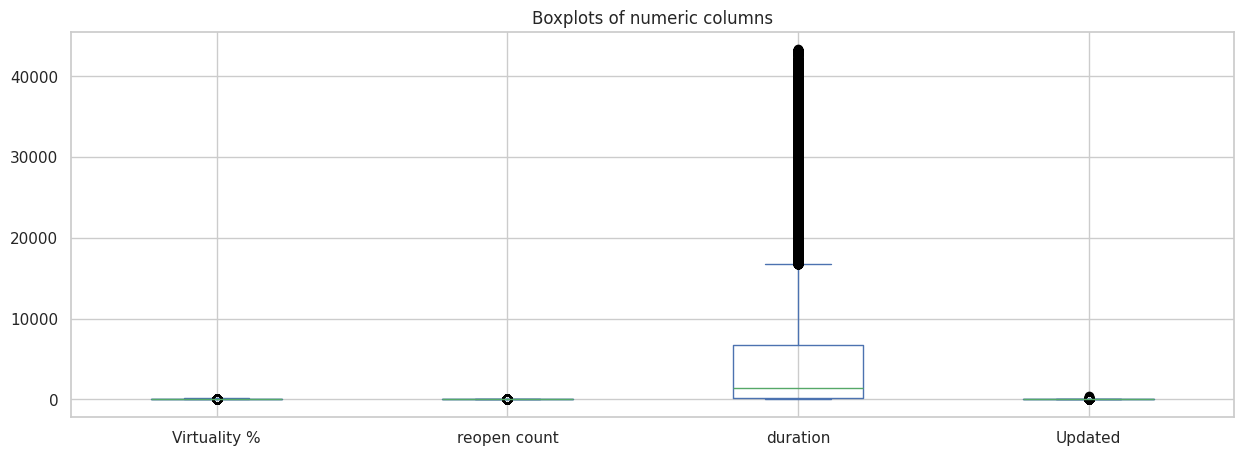

In [9]:
df[numeric_cols].plot.box(figsize=(15,5))
plt.title("Boxplots of numeric columns")
plt.show()

cati out? %   -> in progress


In [10]:
col = 'duration'

In [11]:
Q1= df[col].quantile(0.25)
Q3= df[col].quantile(0.75)
IQR= Q3-Q1

In [12]:
outliers= df[(df[col] < Q1-1.5*IQR) | (df[col] > Q3+1.5*IQR)]

In [13]:
percent_outliers = len(outliers) / len(df) * 100
print(f"Procentul de outlieri în '{col}' este: {percent_outliers:.2f}%")

Procentul de outlieri în 'duration' este: 9.08%


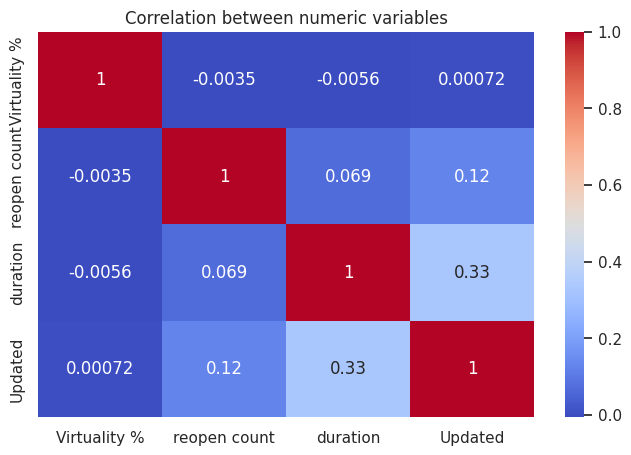

In [14]:
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm").set(title="Correlation between numeric variables")
plt.show()

Date-> DateTime

In [15]:
df['date']= pd.to_datetime(df['date'], dayfirst=True)

Targetul este preventia reopen task


In [16]:
df['task_problematic']= (df['reopen count']>0).astype(int)

Feature-uri

In [17]:
df['day_of_week'] = df['date'].dt.dayofweek  # echipe care pot fi mai productive in anumite yile
df['month'] = df['date'].dt.month    # luni cu mai multe REOPEN
df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)  # task in weekend
df['day_of_year']= df['date'].dt.dayofyear   # luna sau sezon - apogeu REOPEN in perioade aglomerate din an sau la finele anului
df['days_since_start']= (df['date']- df['date'].min()).dt.days   # echipe care devin mai productive dupa o perioada sau learning curve

In [18]:
df['high_virtuality']= (df['Virtuality %']> 80).astype(int)    # daca echipa lucreaza preponderent remote
df['task_long']= (df['duration']> df['duration'].median()).astype(int)   # verif daca durata task ului este mai mare decat val mediana -> task lung = adesea risc mare de reopen deoarece sunt mai complexe
df['multi_updated']= (df['Updated']> df['Updated'].median()).astype(int)   # verif daca un task a fost actualizat mai mult decat valoarea mediana a tuturor task urilot ( task uri cu modificari frecvente)

In [19]:
df['duration_x_virtuality'] = df['duration'] * df['Virtuality %'] # val creste daca task ul e lung si echipa mai mult remote
df['updated_x_duration'] = df['Updated'] * df['duration']    # un task lung cu multe update predispus la erori si REOPEN
df['virtuality_x_updated'] = df['Virtuality %'] * df['Updated']  # echipele remote care fac multe update pot avea risc mare de REOPEN ( remote worl + instability task)

corelatia

Agregare


In [20]:
team_stats = df.groupby('Team ID').agg(
  mean_duration_team = ('duration', 'mean'),    # durata medie a task urilor per echipa
  mean_reopen_team = ('reopen count', 'mean') ,  # media reopen per echipa
  count_task_team = ('duration', 'count'),      # volumul de munca, cate task uri are fiecare echipa
  std_duration_team = ('duration', 'std'),     # deviatia standard a duratei per echipa
).reset_index()

team_stats['pct_tasks_reopened_team'] = team_stats['mean_reopen_team']      # procent task uri reopen per echipa


Merge -> fiecare rand din df primeste statisticile echipei-> istoricul echipei ( pattern la nivel de echipa + task)

In [21]:
df = df.merge(team_stats, on='Team ID', how='left')

In [22]:
 df = df.sort_values(['Team ID', 'date']).reset_index(drop=True)


rolling -> vreau sa aflu daca o echipa lucreaya mai repede sau mai incet , cate task uri recente ai fost REOPEN per echipa , echipele supraincarcate duc la REOPEN

In [23]:
rolling_window = 30   # test with 7 / 14 / 30 days  - analysis
df['rolling_mean_duration_30d'] = df.groupby('Team ID')['duration'].transform(lambda x: x.rolling(rolling_window, min_periods=1).mean())
df['rolling_sum_reopen_30d'] = df.groupby('Team ID')['reopen count'].transform(lambda x: x.rolling(rolling_window, min_periods=1).sum())
df['rolling_count_tasks_30d'] = df.groupby('Team ID')['duration'].transform(lambda x: x.rolling(rolling_window, min_periods=1).count())


Probleme recurente in echipa -> daca o echipa are mai multe task uri REOPEN in palmares-> o crestere a task problematic

In [24]:
def consecutive_reopen(series):
    count = 0
    max_count = 0
    for val in series:
        if val > 0:
            count += 1
            max_count = max(max_count, count)
        else:
            count = 0
    return max_count

consec_reopen = df.groupby('Team ID')['reopen count'].transform(consecutive_reopen)
df['consecutive_reopen_days'] = consec_reopen


Split x si y


In [25]:
features = [
    'Virtuality %', 'duration', 'Updated',
    'day_of_week', 'month', 'is_weekend', 'day_of_year', 'days_since_start',
    'high_virtuality', 'task_long', 'multi_updated',
    'duration_x_virtuality', 'updated_x_duration', 'virtuality_x_updated',
    'mean_duration_team', 'mean_reopen_team', 'count_task_team', 'std_duration_team', 'pct_tasks_reopened_team',
    'rolling_mean_duration_30d', 'rolling_sum_reopen_30d', 'rolling_count_tasks_30d', 'consecutive_reopen_days'
]

X = df[features]
y = df['task_problematic']

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: (59267, 23)
Target shape: (59267,)


Train, Test


In [26]:
from sklearn.model_selection import train_test_split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Random forest

In [28]:
from sklearn.ensemble import RandomForestClassifier

In [36]:
rf_model = RandomForestClassifier(
    n_estimators=500,      # 100 -500
    max_depth=10,
    random_state=42,
    class_weight='balanced' # pentru dezechilibrul clasei
)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=500,
                       random_state=42)

Predictie si evaluare

In [37]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

In [38]:

y_prob = rf_model.predict_proba(X_test)[:, 1]

threshold = 0.786
y_pred = (y_prob > threshold).astype(int)


In [39]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[11473   228]
 [  108    45]]


In [40]:
class_report= classification_report(y_test, y_pred, output_dict= True)
class_report_df= pd.DataFrame(class_report).transpose()
class_report_df

,precision,recall,f1-score,support
0,0.990674,0.980514,0.985568,11701.000000
1,0.164835,0.294118,0.211268,153.000000
accuracy,0.971655,0.971655,0.971655,0.971655
macro avg,0.577755,0.637316,0.598418,11854.000000
weighted avg,0.980015,0.971655,0.975574,11854.000000


In [34]:
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.9445826930607014
